In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import gzip
import seaborn as sns
from IPython.display import display, HTML
sns.set()

In [3]:
def parse(path): 
    g = gzip.open(path, 'rb') 
    for l in g: 
        yield eval(l) 
            
def getDF(path): 
    i = 0 
    df = {} 
    for d in parse(path): 
        df[i] = d 
        i += 1 
        
    return pd.DataFrame.from_dict(df, orient='index') 

In [21]:
df = getDF('data/reviews_Electronics_5.json.gz')

In [23]:
df.to_pickle("serialized_electronics")

In [98]:
df = pd.read_pickle("data/serialized_electronics")

In [99]:
df.head()

,summary,reviewerName,reviewTime,overall,asin,helpful,unixReviewTime,reviewerID,reviewText
0,Gotta have GPS!,amazdnu,"06 2, 2013",5.0,0528881469,"[0, 0]",1370131200,AO94DHGC771SJ,We got this GPS for my husband who is an (OTR)...
1,Very Disappointed,Amazon Customer,"11 25, 2010",1.0,0528881469,"[12, 15]",1290643200,AMO214LNFCEI4,"I'm a professional OTR truck driver, and I bou..."
2,1st impression,C. A. Freeman,"09 9, 2010",3.0,0528881469,"[43, 45]",1283990400,A3N7T0DY83Y4IG,"Well, what can I say. I've had this unit in m..."
3,"Great grafics, POOR GPS","Dave M. Shaw ""mack dave""","11 24, 2010",2.0,0528881469,"[9, 10]",1290556800,A1H8PY3QHMQQA0,"Not going to write a long review, even thought..."
4,"Major issues, only excuses for support",Wayne Smith,"09 29, 2011",1.0,0528881469,"[0, 0]",1317254400,A24EV6RXELQZ63,I've had mine for a year and here's what we go...


## Long reviews

In [100]:
# Compute the length of the review
df['length'] = df.reviewText.str.len()

# Separate the helpful indicator list into two separate columns
df[['helpful_yes','helpful_total']] = pd.DataFrame(df.helpful.values.tolist())
df = df.drop('helpful', axis=1)

# Compute explicitely the number of unhelpul reviews
df['helpful_no'] = df.helpful_total - df.helpful_yes

df.head()

,summary,reviewerName,reviewTime,overall,asin,unixReviewTime,reviewerID,reviewText,length,helpful_yes,helpful_total,helpful_no
0,Gotta have GPS!,amazdnu,"06 2, 2013",5.0,0528881469,1370131200,AO94DHGC771SJ,We got this GPS for my husband who is an (OTR)...,805,0,0,0
1,Very Disappointed,Amazon Customer,"11 25, 2010",1.0,0528881469,1290643200,AMO214LNFCEI4,"I'm a professional OTR truck driver, and I bou...",2175,12,15,3
2,1st impression,C. A. Freeman,"09 9, 2010",3.0,0528881469,1283990400,A3N7T0DY83Y4IG,"Well, what can I say. I've had this unit in m...",4607,43,45,2
3,"Great grafics, POOR GPS","Dave M. Shaw ""mack dave""","11 24, 2010",2.0,0528881469,1290556800,A1H8PY3QHMQQA0,"Not going to write a long review, even thought...",2246,9,10,1
4,"Major issues, only excuses for support",Wayne Smith,"09 29, 2011",1.0,0528881469,1317254400,A24EV6RXELQZ63,I've had mine for a year and here's what we go...,1076,0,0,0


### Length as a function of overall rating

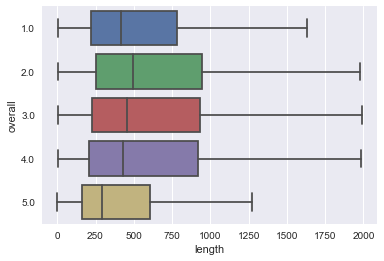

In [58]:
sns.boxplot(y='overall', x='length', data=df[df.length != 0], orient='h', showfliers=False)
plt.show()

### Helpfulness as a function of length

In [107]:
df[df.helpful_yes == df.helpful_yes.max()]

,summary,reviewerName,reviewTime,overall,asin,unixReviewTime,reviewerID,reviewText,length,helpful_yes,helpful_total,helpful_no
1270097,You Get What You Pay For,TL,"09 17, 2012",4.0,B0074BW614,1347840000,A3QCF8CVINEXB8,I've been an iPad user since the original came...,9322,30735,31453,718


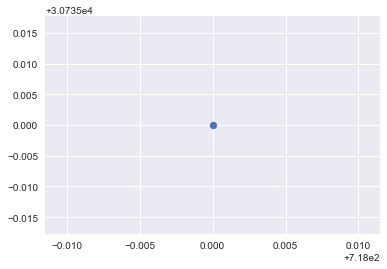

In [132]:
df_rated = df[df.helpful_total > 10000]
plt.scatter(df_rated.helpful_no, df_rated.helpful_yes)
plt.show()

In [111]:
df.corr()

,overall,unixReviewTime,length,helpful_yes,helpful_total,helpful_no
overall,1.000000,0.056556,-0.075156,-0.011774,-0.025633,-0.152076
unixReviewTime,0.056556,1.000000,-0.171947,-0.084347,-0.090959,-0.107652
length,-0.075156,-0.171947,1.000000,0.189538,0.195478,0.147426
helpful_yes,-0.011774,-0.084347,0.189538,1.000000,0.996274,0.406342
helpful_total,-0.025633,-0.090959,0.195478,0.996274,1.000000,0.483631
helpful_no,-0.152076,-0.107652,0.147426,0.406342,0.483631,1.000000


## Group by product

In [25]:
most_reviewed_id = df.asin.value_counts().index[0]

sample = df[df.asin == most_reviewed_id]
sample

,summary,reviewerName,reviewTime,overall,asin,helpful,unixReviewTime,reviewerID,reviewText
1336614,Four Stars,NaN,"07 23, 2014",4.0,B007WTAJTO,"[0, 0]",1406073600,A3SBTW3WS4IQSN,No issues.
1336615,MOAR SPACE!!!,0mie,"10 25, 2013",5.0,B007WTAJTO,"[0, 0]",1382659200,A18K1ODH1I2MVB,"Purchased this for my device, it worked as adv..."
1336616,nothing to really say....,1K3,"12 23, 2012",4.0,B007WTAJTO,"[0, 0]",1356220800,A2FII3I2MBMUIA,it works as expected. I should have sprung for...
1336617,Great buy at this price!!! *** UPDATE,1m2,"11 21, 2013",5.0,B007WTAJTO,"[0, 0]",1384992000,A3H99DFEG68SR,This think has worked out great.Had a diff. br...
1336618,best deal around,2&amp;1/2Men,"07 13, 2013",5.0,B007WTAJTO,"[0, 0]",1373673600,A375ZM4U047O79,"Bought it with Retail Packaging, arrived legit..."
1336619,Not a lot to really be said,2Cents!,"04 29, 2013",5.0,B007WTAJTO,"[0, 0]",1367193600,A2IDCSC6NVONIZ,It's mini storage. It doesn't do anything els...
1336620,Works well,2K1Toaster,"10 19, 2013",5.0,B007WTAJTO,"[0, 0]",1382140800,A26YHXZD5UFPVQ,I have it in my phone and it never skips a bea...
1336621,32 GB for less than two sawbucks...what's not ...,"35-year Technology Consumer ""8-tracks to 802.11""","07 10, 2014",5.0,B007WTAJTO,"[0, 0]",1404950400,A3CW0ZLUO5X2B1,It's hard to believe how affordable digital ha...
1336622,Loads of room,4evryoung,"03 24, 2014",5.0,B007WTAJTO,"[1, 1]",1395619200,A2CYJO155QP33S,Works in a HTC Rezound. Was running short of ...
1336623,works great,53rdcard,"10 11, 2013",5.0,B007WTAJTO,"[0, 0]",1381449600,A2S7XG3ZC4VGOQ,"in my galaxy s4, super fast card, and am total..."


count    1.688117e+06
mean     6.346041e+02
std      9.031595e+02
min      1.000000e+00
25%      1.770000e+02
50%      3.420000e+02
75%      7.240000e+02
max      3.270300e+04
Name: reviewText, dtype: float64


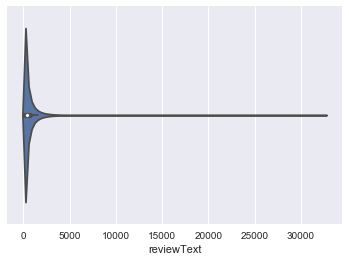

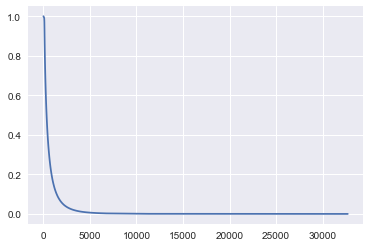

In [26]:
lengths = df['reviewText'].str.len()
lengths = lengths[(lengths > 0)]
print(lengths.describe())
sns.violinplot(lengths)
plt.show()

lengths_sorted = lengths.sort_values()
y = np.array(list(range(len(lengths_sorted))))
y = y / len(lengths_sorted)
y = y[::-1]
lengths_sorted.head()
plt.plot(lengths_sorted, y)
plt.show()

# Natural language processing

In [8]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [9]:
from nltk.book import *

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


In [27]:
reviewText = sample.reviewText.copy()
reviewText = reviewText.str.split()
raw = [element for list_ in reviewText for element in list_]

In [30]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = TrigramCollocationFinder.from_words(raw)
finder.apply_freq_filter(7)
finder.nbest(trigram_measures.pmi, 1000)

[('EaseUS', 'Partition', 'Master'),
 ('IOPS]Random', 'Write', '4KB'),
 ('4KB', '(QD=1)', ':'),
 ('4KB', '(QD=32)', ':'),
 ('MicroSDHC', 'C10/UHS1', 'Memory'),
 ('Dell', 'Venue', '8'),
 ('Microsoft', 'Surface', 'RT'),
 ('microSDHC', 'Flash', 'Memory'),
 ('C10/UHS1', 'Memory', 'Card'),
 ('GB', 'MicroSDHC', 'C10/UHS1'),
 ('.', '.', '.'),
 ('go', 'pro', 'hero'),
 ('Flash', 'Memory', 'Card'),
 ('Venue', '8', 'Pro'),
 ('UHS-1', 'Memory', 'Card'),
 ('Note', '10.1', '2014'),
 ('Microsoft', 'Surface', 'Pro'),
 ('Galaxy', 'S', 'III.'),
 ('San', 'Disk', 'Ultra'),
 ('Galaxy', 'S', 'III'),
 ('Tab', '2', '7.0'),
 ('Other', 'than', 'that,'),
 ("Can't", 'go', 'wrong'),
 ('10', 'UHS-1', 'Memory'),
 ('Hero', '3', 'Black'),
 ("can't", 'go', 'wrong'),
 ('GoPro', 'Hero', '3'),
 ('64', 'GB', 'microSDXC'),
 ('worry', 'about', 'running'),
 ('32', 'GB', 'MicroSDHC'),
 ('Class', '10', 'UHS-1'),
 ('microSDXC', 'Class', '10'),
 ('GB', 'microSDXC', 'Class'),
 ('my', 'LG', 'Optimus'),
 ('immediately', 'recognized',

## Tagging words

In [12]:
from nltk import word_tokenize
text = word_tokenize("And now for something completely different")
nltk.pos_tag(text)

[('And', 'CC'),
 ('now', 'RB'),
 ('for', 'IN'),
 ('something', 'NN'),
 ('completely', 'RB'),
 ('different', 'JJ')]

In [201]:
print(nltk.pos_tag(word_tokenize("well")))
print(nltk.pos_tag(word_tokenize("made")))

[('well', 'RB')]
[('made', 'VBN')]


In [198]:
nltk.help.upenn_tagset('VBN')

VBN: verb, past participle
    multihulled dilapidated aerosolized chaired languished panelized used
    experimented flourished imitated reunifed factored condensed sheared
    unsettled primed dubbed desired ...


In [174]:
good = wn.synset('good.n.01')
good.lemmas()[0].pertainyms()

[]

In [206]:
for synset in wn.synsets('great'):
    print(synset.lemma_names())
    print(synset.hyponyms())

['great']
[]
['great']
[]
['great', 'outstanding']
[]
['great']
[]
['bang-up', 'bully', 'corking', 'cracking', 'dandy', 'great', 'groovy', 'keen', 'neat', 'nifty', 'not_bad', 'peachy', 'slap-up', 'swell', 'smashing']
[]
['capital', 'great', 'majuscule']
[]
['big', 'enceinte', 'expectant', 'gravid', 'great', 'large', 'heavy', 'with_child']
[]


In [213]:
tmp = wn.synset('good.a.01')
print(tmp.path_similarity(wn.synset('best.a.01')))

None


## Sentiment analysis

In [14]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn

In [19]:
class SentimentAnalyser:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        
    def _penn_to_wn(self, tag):
        """
        Convert between the PennTreebank tags to simple Wordnet tags
        """
        if tag.startswith('J'):
            return wn.ADJ
        elif tag.startswith('N'):
            return wn.NOUN
        elif tag.startswith('R'):
            return wn.ADV
        elif tag.startswith('V'):
            return wn.VERB
        return None

    def sentiment_for_tagged_word(self, tagged_word):
        """
        Compute the score for a given tagged word.
        The word is assumed to be tagged using the Penn Treebank Project's tags
        Return None for irrelevant words, a tuple (positive score, negative score) otherwise
        """
        word, tag = tagged_word
        
        wn_tag = self._penn_to_wn(tag)
        
        if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
            return None
        
        lemma = self.lemmatizer.lemmatize(word, pos=wn_tag)
        
        if not lemma:
            return None
        
        synsets = wn.synsets(lemma, pos=wn_tag)
        
        if not synsets:
            return None
        
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        
        return swn_synset.pos_score(), swn_synset.neg_score()
    
    def sentiment_score_for_raw_sentence(self, raw_sentence):
        """
        Compute the sum of the differences in sentiment score for each word in the sentence
        """
        tagged_sentence = nltk.pos_tag(word_tokenize(raw_sentence))
        sum_deltas = 0

        for tagged_word in tagged_sentence:
            scores = self.sentiment_for_tagged_word(tagged_word)

            if scores is None:
                continue
                
            pos_score, neg_score = scores
            sum_deltas += (pos_score - neg_score)
        
        return sum_deltas
        


In [20]:
s = SentimentAnalyser()
a = s.sentiment_score_for_raw_sentence("Certainly the best book I have ever read")
a

1.0

In [172]:
raw_sentence = "Dankest object in the whole fucking world"
tagged_sentence = nltk.pos_tag(word_tokenize(raw_sentence))

for word, tag in tagged_sentence:
    wn_tag = penn_to_wn(tag)
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        continue

    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        continue

    synsets = wn.synsets(lemma, pos=wn_tag)
    if not synsets:
        continue

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    print(swn_synset)
    print(swn_synset.pos_score())
    print(swn_synset.neg_score())


<clammy.s.01: PosScore=0.0 NegScore=0.25>
0.0
0.25
<object.n.01: PosScore=0.0 NegScore=0.0>
0.0
0.0
<whole.a.01: PosScore=0.125 NegScore=0.0>
0.125
0.0
<fuck.n.01: PosScore=0.0 NegScore=0.0>
0.0
0.0
<universe.n.01: PosScore=0.0 NegScore=0.0>
0.0
0.0
